In [105]:
import tensorflow as tf
from emnist import extract_training_samples, extract_test_samples

# Загрузка тренировочных данных
train_images, train_labels = extract_training_samples('letters')

# Загрузка тестовых данных
test_images, test_labels = extract_test_samples('letters')

INFO:emnist:Cached file found at C:\Users\23202/.cache/emnist/emnist.zip.
INFO:emnist:Cached file found at C:\Users\23202/.cache/emnist/emnist.zip.
INFO:emnist:Cached file found at C:\Users\23202/.cache/emnist/emnist.zip.
INFO:emnist:Cached file found at C:\Users\23202/.cache/emnist/emnist.zip.


In [106]:
emnist_mapping = {
    1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J',
    11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T',
    21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z',
    27: 'a', 28: 'b', 29: 'c', 30: 'd', 31: 'e', 32: 'f', 33: 'g', 34: 'h', 35: 'i', 36: 'j',
    37: 'k', 38: 'l', 39: 'm', 40: 'n', 41: 'o', 42: 'p', 43: 'q', 44: 'r', 45: 's', 46: 't',
    47: 'u', 48: 'v', 49: 'w', 50: 'x', 51: 'y', 52: 'z'
}

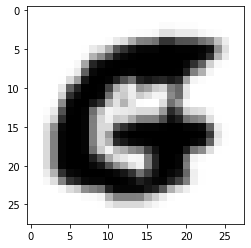

7


In [107]:
import matplotlib.pyplot as plt
plt.imshow(train_images[1],cmap=plt.cm.binary)
plt.show()
print(train_labels[1])

In [108]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [109]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [110]:
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Sequential

model1 = Sequential()
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(27, activation='softmax'))

In [111]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [112]:
model1.fit(train_images, train_labels, epochs=50, batch_size=64)

Epoch 1/50
1950/1950 [==============================] - 9s 4ms/step - loss: 0.8363 - accuracy: 0.7581
Epoch 2/50
1950/1950 [==============================] - 7s 4ms/step - loss: 0.4708 - accuracy: 0.8572
Epoch 3/50
1950/1950 [==============================] - 8s 4ms/step - loss: 0.3899 - accuracy: 0.8792
Epoch 4/50
1950/1950 [==============================] - 8s 4ms/step - loss: 0.3461 - accuracy: 0.8912
Epoch 5/50
1950/1950 [==============================] - 8s 4ms/step - loss: 0.3191 - accuracy: 0.8986
Epoch 6/50
1950/1950 [==============================] - 7s 4ms/step - loss: 0.2977 - accuracy: 0.9050
Epoch 7/50
1950/1950 [==============================] - 7s 4ms/step - loss: 0.2808 - accuracy: 0.9094
Epoch 8/50
1950/1950 [==============================] - 7s 4ms/step - loss: 0.2682 - accuracy: 0.9127
Epoch 9/50
1950/1950 [==============================] - 7s 4ms/step - loss: 0.2573 - accuracy: 0.9161
Epoch 10/50
1950/1950 [==============================] - 7s 4ms/step - loss: 0.246

In [113]:
test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

650/650 [==============================] - 3s 4ms/step - loss: 0.5315 - accuracy: 0.8867
test_acc: 0.8866826891899109


In [117]:
from scipy.ndimage import center_of_mass
import math 
import cv2
import numpy as np

def getBestShift(img):
    cy,cx = center_of_mass(img)
    
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty
  
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted
    
def rec_digit(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gray = 255-img
    # применяем пороговую обработку
    (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # удаляем нулевые строки и столбцы
    while np.sum(gray[0]) == 0:
        gray = gray[1:]
    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)
    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]
    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)
    rows,cols = gray.shape
  
    # изменяем размер, чтобы помещалось в box 20x20 пикселей
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray, (cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows))

  # расширяем до размера 28x28
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')


    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    gray = shifted
  
    img = gray / 255.0
    img = np.array(img).reshape(-1, 28, 28, 1)
    print(f"Распознанная буква моделью: {emnist_mapping[(np.argmax(model1.predict(img)))]}")